<a href="https://colab.research.google.com/github/GitAmitesh/SkinDiseaseClassificationCNN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Disease Classification using CNN


### Imports

In [79]:
import zipfile
import os
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.utils import resample

### Files extraction

##### DO NOT RUN THE EXTRACTION AGAIN AFTER FIRST EXECUTION

In [80]:
# !fusermount -u drive
# drive.mount('/content/drive')

# # Define the path of your ZIP file
# zip_path = "/content/drive/MyDrive/HAM10000/HAM10000.zip"  # Change this to your actual file path
# extraction_path = "/content/drive/MyDrive/HAM10000/"  # Change this to your desired extraction path

# # Extract the ZIP file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extraction_path)  # Extract into a specific folder

# print("Dataset Extracted Successfully!")

In [81]:
extraction_path = "/content/drive/MyDrive/HAM10000/"
print("Folders and files inside dataset:")
print(os.listdir(extraction_path))  # Lists extracted files & folders

Folders and files inside dataset:
['HAM10000.zip', 'HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'ham10000_images_part_1', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv', 'augmented_images', 'balanced_metadata.csv']


In [82]:
# Load metadata CSV file
metadata_path = os.path.join(extraction_path, "HAM10000_metadata.csv")  # Ensure correct file name
df = pd.read_csv(metadata_path)

# Display first few rows
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [83]:
# Get all image file paths
image_paths1 = glob.glob(os.path.join(extraction_path, "HAM10000_images_part_1", "*.jpg"))
image_paths2 = glob.glob(os.path.join(extraction_path, "HAM10000_images_part_2", "*.jpg"))

# Merge both image lists
all_image_paths = image_paths1 + image_paths2

# Convert list to dictionary for easy lookup
image_path_dict = {os.path.basename(path): path for path in all_image_paths}

# Add image paths to DataFrame
df["image_path"] = df["image_id"].map(lambda id: image_path_dict.get(id + ".jpg"))

# Display updated DataFrame
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/HAM10000/HAM10000_image...


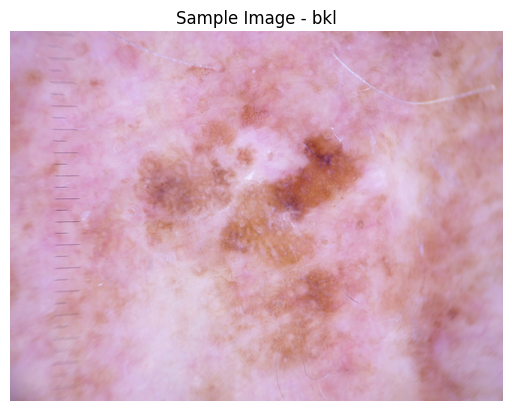

In [84]:
# Load and display a sample image using Matplotlib
sample_image_path = df.iloc[0]["image_path"]  # Get the image path
image = mpimg.imread(sample_image_path)  # Read the image as an array

plt.imshow(image)  # Display the image
plt.axis("off")  # Hide axes
plt.title(f"Sample Image - {df.iloc[0]['dx']}")  # Add title with disease label
plt.show()  # Show the image


In [85]:
df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
image_path,0


In [86]:
# The feature 'age' consists of 57 null records. Thus, we need to replace them with the mean of 'age' since dropping 57 records would lead to loss of data.
df['age'].fillna(int(df['age'].mean()),inplace=True)
df.isnull().sum()
# now the nulls are removed

<ipython-input-86-197812b8994a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(int(df['age'].mean()),inplace=True)


,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0
image_path,0


In [87]:
# Define the dictionary mapping lesion codes to their full names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Map diagnosis labels to full cell type names
df['lesion_type'] = df['dx'].map(lesion_type_dict.get)

# Encode cell type labels as numerical values
df['lesion_type_idx'] = pd.Categorical(df['lesion_type']).codes

# Display the first few rows
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,lesion_type,lesion_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/HAM10000/HAM10000_image...,Benign keratosis-like lesions,2


<ipython-input-88-0031d229d10b>:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


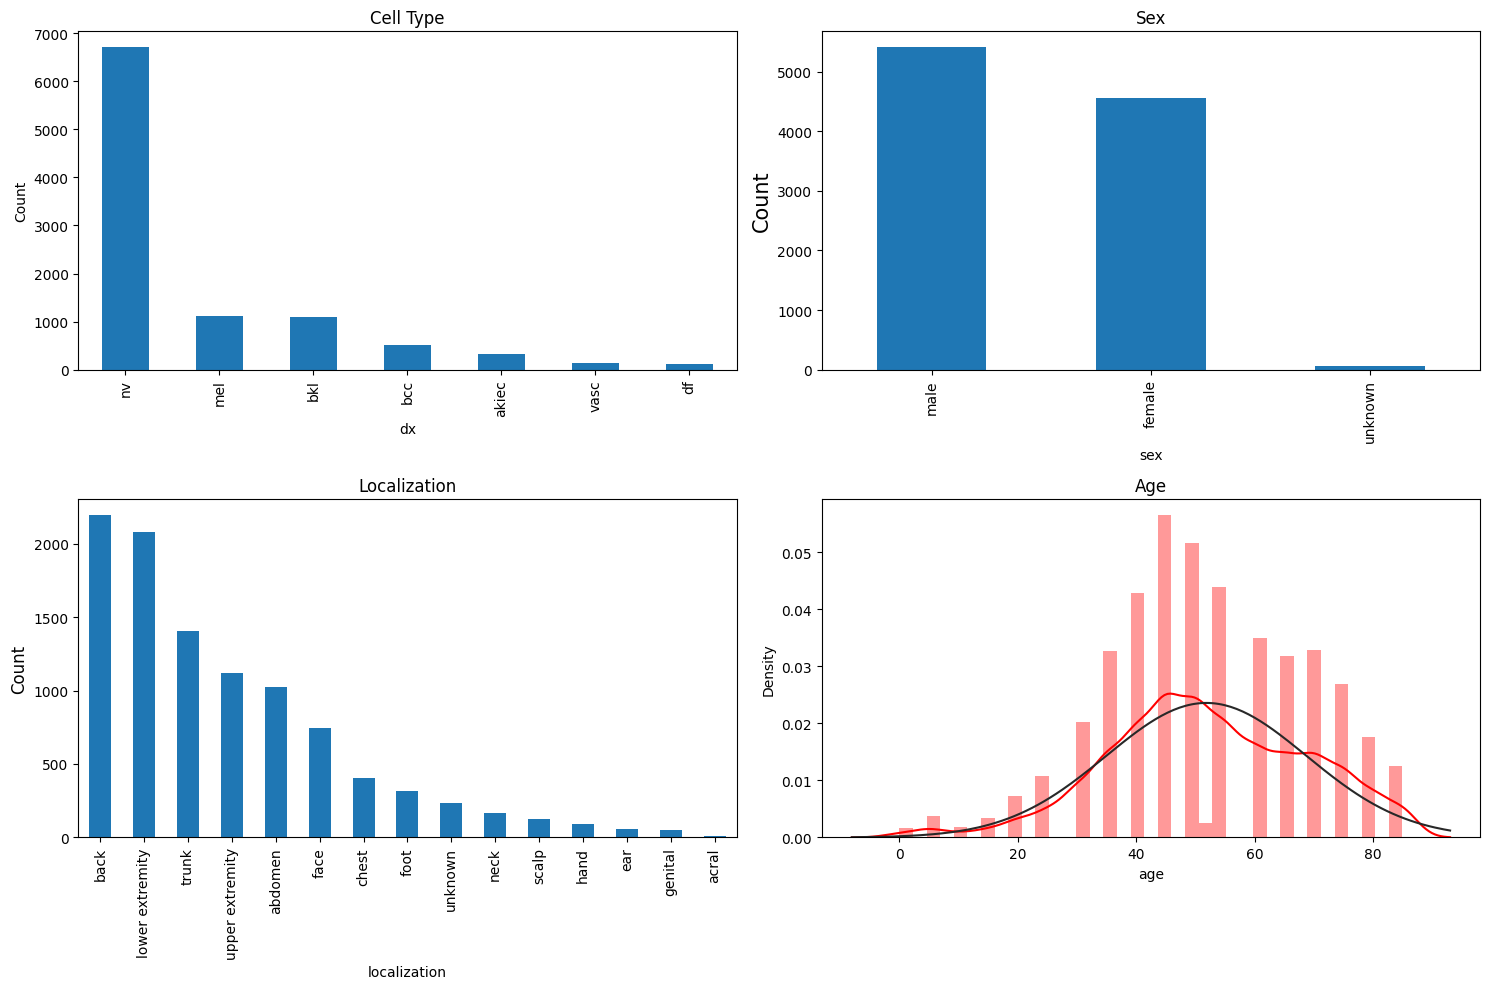

In [88]:
# Data distribution visualization
from scipy import stats
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = df[pd.notnull(df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

According to "dx" graph plot, we can observe that the dataset is heavily unbalanced and needs to be balanced using data augmentation. Data augmentation is a technique that artificially increases the size and diversity of a dataset by creating modified copies of existing data, improving model performance and robustness, especially when dealing with limited data.


In [89]:
print("Number of data points per cell type before augmentation:")
print(df['lesion_type'].value_counts())

Number of data points per cell type before augmentation:
lesion_type
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64


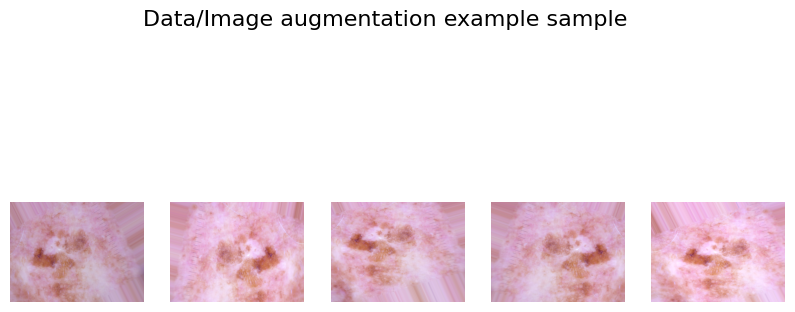

In [90]:
# Define augmentation techniques
datagen = ImageDataGenerator(
    rotation_range=30,      # Rotate images up to 30 degrees
    width_shift_range=0.1,  # Shift width by 10%
    height_shift_range=0.1, # Shift height by 10%
    shear_range=0.2,        # Shear transformation
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Flip horizontally
    brightness_range=[0.8, 1.2],  # Vary brightness/contrast randomly
    fill_mode='nearest'     # Fill missing pixels after transformation
)

# Example: Augment a sample image
sample_image = cv2.imread(df.iloc[0]['image_path'])  # Read first image
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
sample_image = sample_image.reshape((1,) + sample_image.shape)  # Reshape for augmentation

# Generate augmented images and display them
plt.figure(figsize=(10, 5))
plt.suptitle("Data/Image augmentation example sample", fontsize=16)
for i, batch in enumerate(datagen.flow(sample_image, batch_size=1)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
    if i == 4: break  # Show only 5 examples
plt.show()

In [91]:
# # Define dataset path
# base_skin_dir = extraction_path

# # Define target samples per class
# target_samples = 1430  # Augment minority classes to the average of all count values
# nv_samples = 2000  # Downsample 'nv' class to this number

# # Create a folder to save augmented images
# augmented_dir = extraction_path + "augmented_images/"
# os.makedirs(augmented_dir, exist_ok=True)

# # Resample the majority class (nv) down to 2000
# df_nv = df[df["dx"] == "nv"]
# df_nv_downsampled = resample(df_nv, replace=False, n_samples=nv_samples, random_state=42)

# # Function to perform data augmentation
# def augment_images(df_subset, target_size, class_label):
#     augmented_data = []
#     deficit = target_size - len(df_subset)

#     images = df_subset["image_path"].values
#     for i in range(deficit):
#         img_path = np.random.choice(images)  # Pick a random image
#         image = cv2.imread(img_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = image.reshape((1,) + image.shape)  # Reshape for augmentation

#         # Generate augmented image
#         for batch in datagen.flow(image, batch_size=1):
#             new_image = batch[0].astype("uint8")

#             # Generate a unique filename
#             new_filename = f"aug_{class_label}_{np.random.randint(100000)}.jpg"
#             new_image_path = os.path.join(augmented_dir, new_filename)

#             # Save the augmented image
#             cv2.imwrite(new_image_path, cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR))

#             # Get metadata from original image
#             original_metadata = df_subset.iloc[0].copy()
#             original_metadata["image_path"] = new_image_path  # Update image path

#             # Append new metadata
#             augmented_data.append(original_metadata)
#             break  # Only generate one per iteration

#     return pd.DataFrame(augmented_data)

# # List of minority classes to augment
# minority_classes = ["mel", "bkl", "bcc", "akiec", "vasc", "df"]

# # Apply augmentation to each minority class
# augmented_dfs = []
# for cell_type in minority_classes:
#     df_subset = df[df["dx"] == cell_type]
#     augmented_df = augment_images(df_subset, target_samples, cell_type)
#     augmented_dfs.append(augmented_df)

# # Combine downsampled 'nv', augmented classes, and original 'nv'
# balanced_df = pd.concat([df_nv_downsampled] + augmented_dfs, ignore_index=True)

# # Shuffle dataset for randomness
# balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Save new balanced metadata
# balanced_metadata_path = extraction_path + "balanced_metadata.csv"
# balanced_df.to_csv(balanced_metadata_path, index=False)

In [92]:
# Import the balanced metadata
balanced_metadata_path = extraction_path + "balanced_metadata.csv"
balanced_df_imported = pd.read_csv(balanced_metadata_path)

# Exclude all "Melanocytic nevi" (nv) from the original df
df_filtered = df[df["dx"] != "nv"]

# Combine with original df
combined_df = pd.concat([df_filtered, balanced_df_imported], ignore_index=True)

# Reshuffle the combined DataFrame
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print new value counts
print("Dataset distribution of augmented data:\n")
print(balanced_df_imported["lesion_type"].value_counts())
print("\nNew dataset distribution after augmentation:\n")
print(combined_df["lesion_type"].value_counts())
print("\nTotal number of data:\n")
print(combined_df.shape[0])

Dataset distribution of augmented data:

lesion_type
Melanocytic nevi                 2000
Dermatofibroma                   1315
Vascular lesions                 1288
Actinic keratoses                1103
Basal cell carcinoma              916
Benign keratosis-like lesions     331
Melanoma                          317
Name: count, dtype: int64

New dataset distribution after augmentation:

lesion_type
Melanocytic nevi                 2000
Vascular lesions                 1430
Benign keratosis-like lesions    1430
Dermatofibroma                   1430
Actinic keratoses                1430
Melanoma                         1430
Basal cell carcinoma             1430
Name: count, dtype: int64

Total number of data:

10580


In [93]:
combined_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,lesion_type,lesion_type_idx
0,HAM_0006889,ISIC_0031197,vasc,histo,20.0,male,upper extremity,/content/drive/MyDrive/HAM10000/augmented_imag...,Vascular lesions,6
1,HAM_0003810,ISIC_0034309,nv,consensus,40.0,male,unknown,/content/drive/MyDrive/HAM10000/HAM10000_image...,Melanocytic nevi,4
2,HAM_0003933,ISIC_0029854,nv,histo,55.0,female,upper extremity,/content/drive/MyDrive/HAM10000/HAM10000_image...,Melanocytic nevi,4
3,HAM_0001279,ISIC_0025855,nv,histo,50.0,female,back,/content/drive/MyDrive/HAM10000/HAM10000_image...,Melanocytic nevi,4
4,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,/content/drive/MyDrive/HAM10000/HAM10000_image...,Melanocytic nevi,4
